In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import json
from PIL import Image
import ipyplot
import random
from scipy.special import softmax
from scipy import stats
from scipy.stats import bernoulli
import random, math
import statsmodels.api as sm
import choix
import networkx as nx
from pathlib import Path
from shutil import copy2
from prettytable import PrettyTable
from PIL import Image
import requests
from io import BytesIO
from matplotlib.lines import Line2D
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from string import ascii_letters


pd.options.display.max_rows = 100
random_state = 42

In [2]:
df_results = pd.read_pickle('data/df_results.pickle')

In [3]:
df_results['category'] = df_results['category'].apply(lambda x: 'vegetable' if x=='tegetable' else x)

In [4]:
df_results = df_results.sort_values(by = 'category', ascending = False)

In [5]:
df_results['category'] = df_results['category'].apply(lambda x: 'OVERALL' if x=='A_overall' else x)

In [6]:
#df_results = df_results[:-4]

In [7]:
len(df_results)

100

## a) Fraction wins

In [8]:
outcomes = ['Answer.tasty','Answer.caloric','Answer.healthy','Answer.homemade']

In [9]:
categories = df_results['category'].unique()

In [10]:
df_results.loc[df_results['category'] == 'OVERALL'][['outcome','wins_twitter','wins_p_val']]

,outcome,wins_twitter,wins_p_val
96,Answer.tasty,0.617325,6.947260e-141
97,Answer.healthy,0.459645,5.163395e-18
98,Answer.caloric,0.584623,7.119319e-74
99,Answer.homemade,0.380849,2.755351e-145


Text(-0.02, 0.5, 'Food category')

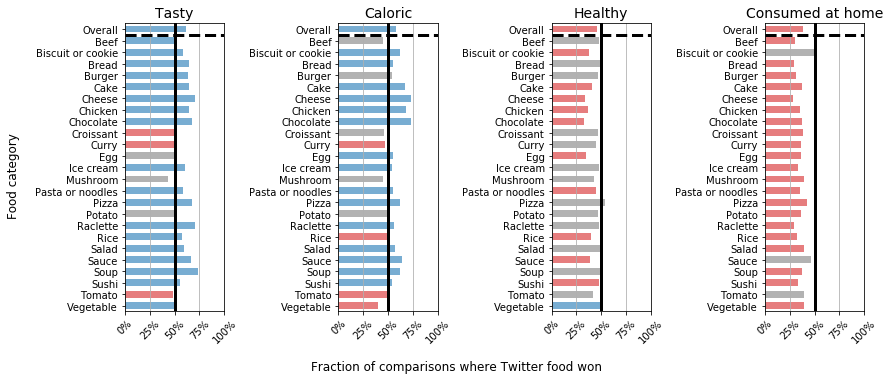

In [11]:
fig, axes = plt.subplots(1,4, figsize = (12,5), sharex = True, sharey = False)

for c,outcome in enumerate(outcomes):
    sbplt = axes[c]
    
    colors = []
    for cnt,i in enumerate(df_results.loc[df_results['outcome'] == outcome]['wins_p_val']<.05):
        if i and df_results.loc[df_results['outcome'] == outcome]['wins_twitter'].values[cnt]>0.5:
            colors.append('tab:blue')
        elif i and df_results.loc[df_results['outcome'] == outcome]['wins_twitter'].values[cnt]<0.5:
            colors.append('tab:red')
        else:
            colors.append('Gray')

    sbplt.barh(range(25),df_results.loc[df_results['outcome'] == outcome]['wins_twitter'],
               color = colors, 
               height = 0.6, alpha = 0.6)
    sbplt.set_yticks(range(25))
    sbplt.set_yticklabels(df_results.loc[df_results['outcome'] == outcome]['category'].apply(lambda x: x.capitalize()), rotation = 0);
    
    sbplt.set_xticks([0,0.25,0.5,0.75,1])
    sbplt.set_xticklabels(["0%","25%","50%","75%","100%"], rotation = 45)
    sbplt.set_xlim([0,1])
    sbplt.set_ylim([-0.4,24.5])
    sbplt.hlines(23.5,0,1, linestyle = '--', linewidth = 3)
    sbplt.vlines(0.5,-1,25, linewidth = 3)
    if outcome == 'Answer.homemade':
        sbplt.set_title('Consumed at home', fontsize= 14)
    else:
        sbplt.set_title(outcome.split('.')[1].capitalize(), fontsize= 14)
    sbplt.grid(axis='x')
fig.tight_layout()

fig.text(0.5, -0.04, 'Fraction of comparisons where Twitter food won', ha='center', fontsize= 12)
fig.text(-0.02, 0.5, 'Food category', va='center', rotation='vertical', fontsize= 12)


## b) Curves rank - multiples

In [12]:
df_results = df_results.loc[df_results['category']!='OVERALL']

In [13]:
categories = df_results['category'].unique()

In [14]:
def check_significance(upper,lower):
    if upper > 50 and lower>50:
        sign = True
    elif upper < 50 and lower<50:
        sign = True
    else:
        sign = False
    return sign

In [15]:
def make_figure(outcome,outcome_cnt):
    colors = ['tab:blue','tab:red','tab:green','tab:orange']
    fig, axes = plt.subplots(6,4, figsize = (7,10), sharex = False, sharey = False)

    for cnt,cat in enumerate(categories[::-1]):
        sbplt = axes[math.floor(cnt/4), cnt%4]
        
        a,b = df_results.loc[(df_results['category'] == cat) \
            & (df_results['outcome'] == outcome)].iloc[0]\
            [['median_twitter_lower_error','median_twitter_upper_error']].values
        sign = (check_significance(a,b))

        lower_error = df_results.loc[(df_results['category'] == cat) \
                   & (df_results['outcome'] == outcome)].iloc[0]['ranks_twitter_lower_error']

        upper_error = df_results.loc[(df_results['category'] == cat) \
                       & (df_results['outcome'] == outcome)].iloc[0]['ranks_twitter_upper_error']

        bootstrapped_estimate = df_results.loc[(df_results['category'] == cat) \
                       & (df_results['outcome'] == outcome)].iloc[0]['ranks_twitter_bootstrapped_estimate']

        if sign:
            sbplt.fill_between(list(range(1,100)),lower_error, upper_error, color = colors[outcome_cnt], alpha = 0.2, \
                         label = "95% bootstrapped confience intervals,\nresampling comparisons and estimating quality")

            sbplt.plot(list(range(1,100)),bootstrapped_estimate, color = colors[outcome_cnt])
        else:
            sbplt.fill_between(list(range(1,100)),lower_error, upper_error, color = 'gray', alpha = 0.2, \
                         label = "95% bootstrapped confience intervals,\nresampling comparisons and estimating quality")

            sbplt.plot(list(range(1,100)),bootstrapped_estimate, color = 'gray')

        sbplt.plot([0,100],[0,100],linestyle = '--', color = 'gray')
        sbplt.set_xlim([0,100])
        sbplt.set_ylim([0,100])


        sbplt.set_xticks(range(0,120,20))
        sbplt.set_yticks(range(0,120,20))
        
        sbplt.set_title(cat.capitalize())
        sbplt.grid(color = 'lightgray')

    fig.tight_layout()

    fig.text(0.5, -0.04,'Percentile among Twitter food', ha='center', fontsize= 12)
    fig.text(-0.04, 0.5, 'Percentile among consumed food', va='center', rotation='vertical', fontsize= 12)

    if outcome == 'Answer.homemade':
        fig.suptitle('Consumed at home', y = 1.05, fontsize=14)
    else:
        fig.suptitle(outcome.split('.')[1].capitalize(), y = 1.05, fontsize=14)
    plt.savefig('figures/curves' + outcome+'.pdf')
    

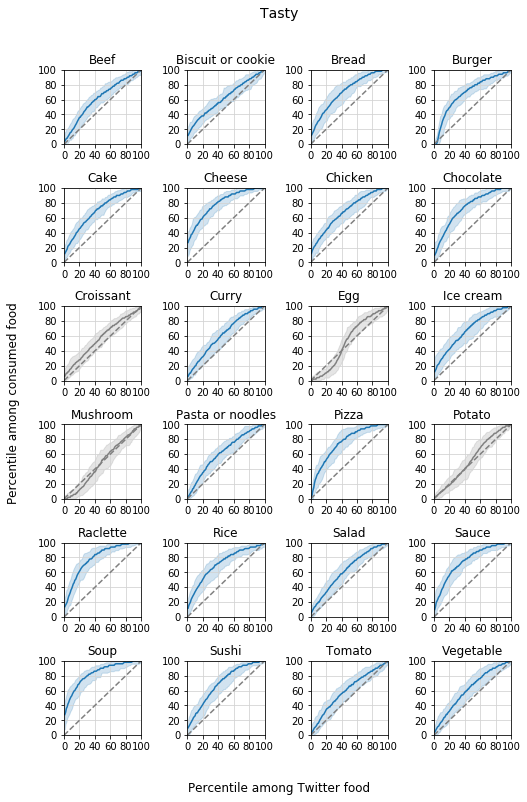

In [16]:
make_figure(outcomes[0],0)

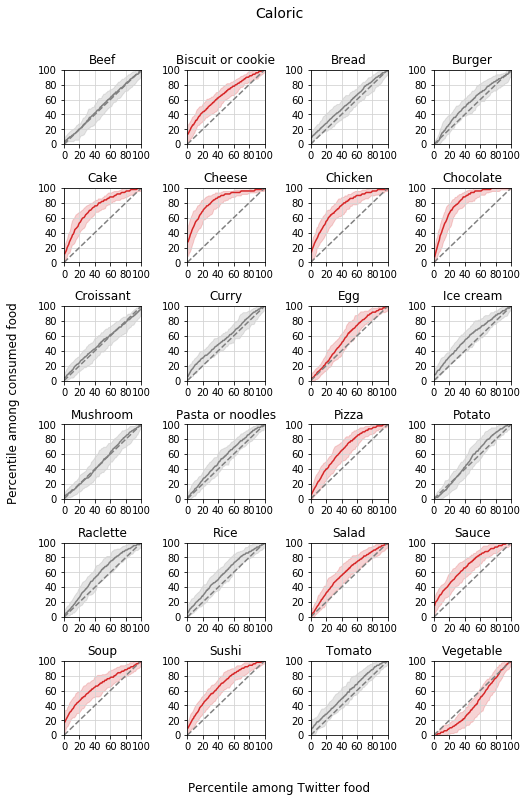

In [17]:
make_figure(outcomes[1],1)

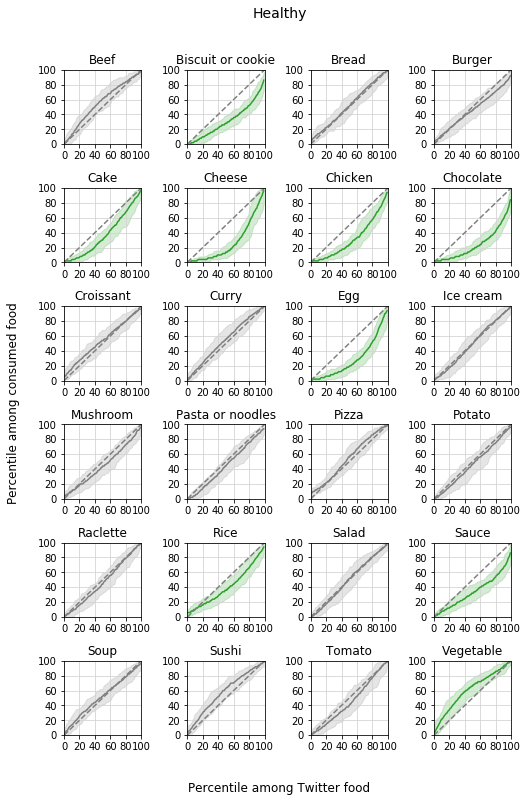

In [18]:
make_figure(outcomes[2],2)

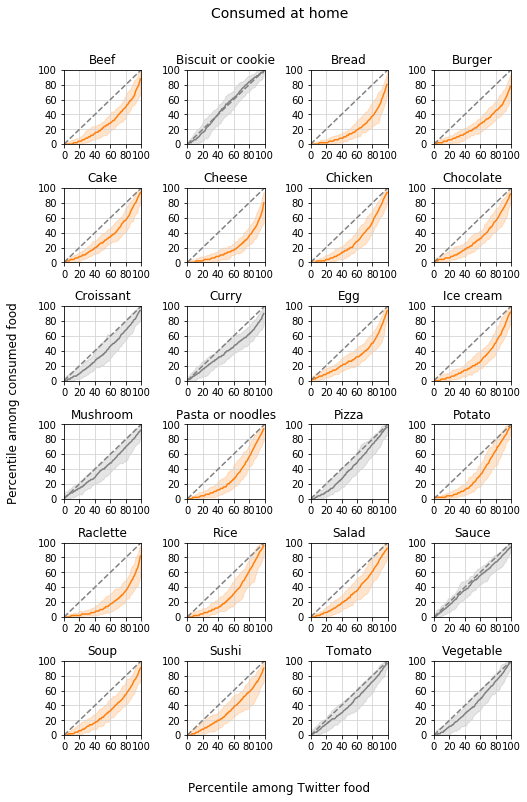

In [19]:
make_figure(outcomes[3],3)

## c) Curves rank - together

In [20]:
outcomes

['Answer.tasty', 'Answer.caloric', 'Answer.healthy', 'Answer.homemade']

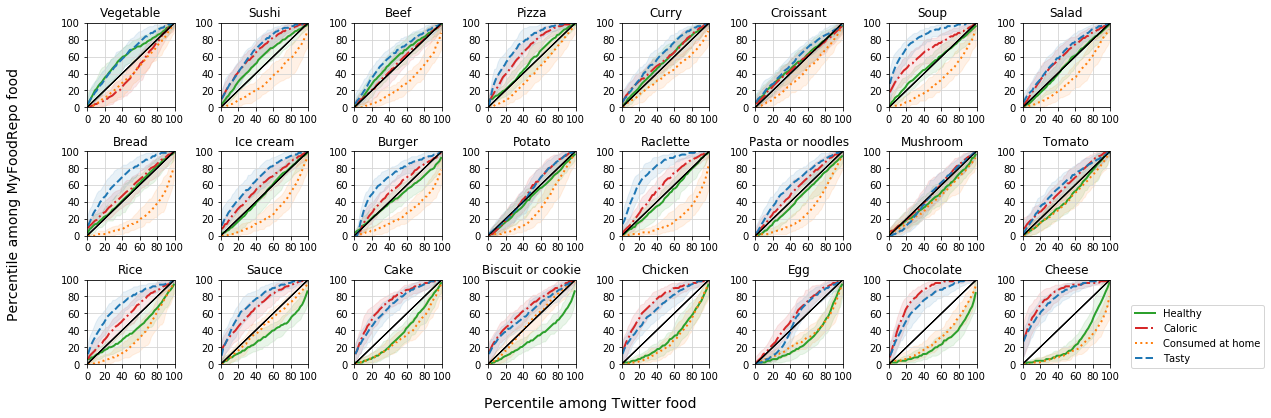

In [21]:
colors = ['tab:green','tab:red','tab:orange','tab:blue']
styles = ['solid','dashdot','dotted','dashed']
#styles = ['solid','solid','solid','solid']
fig, axes = plt.subplots(3,8, figsize = (15,5.5), sharex = False, sharey = False)

sorted_cats = df_results.loc[(df_results['outcome'] == outcomes[2])].sort_values\
(by = 'median_twitter_bootstrapped_estimate')['category'].values[::-1]

for cnt,cat in enumerate(sorted_cats):
    sbplt = axes[math.floor(cnt/8), cnt%8]
    
    for outcome_cnt,outcome in enumerate(['Answer.healthy', 'Answer.caloric',  'Answer.homemade','Answer.tasty']):
        
        a,b = df_results.loc[(df_results['category'] == cat) \
            & (df_results['outcome'] == outcome)].iloc[0]\
            [['median_twitter_lower_error','median_twitter_upper_error']].values
        sign = (check_significance(a,b))
        
        lower_error = df_results.loc[(df_results['category'] == cat) \
                   & (df_results['outcome'] == outcome)].iloc[0]['ranks_twitter_lower_error']

        upper_error = df_results.loc[(df_results['category'] == cat) \
                       & (df_results['outcome'] == outcome)].iloc[0]['ranks_twitter_upper_error']

        bootstrapped_estimate = df_results.loc[(df_results['category'] == cat) \
                       & (df_results['outcome'] == outcome)].iloc[0]['ranks_twitter_bootstrapped_estimate']


        if sign:
            sbplt.fill_between(list(range(1,100))[::2],lower_error[::2], upper_error[::2], color = colors[outcome_cnt], alpha = 0.1, \
                         )

            sbplt.plot(list(range(1,100))[::2],bootstrapped_estimate[::2], linewidth = 2,  color = colors[outcome_cnt], linestyle = styles[outcome_cnt])
        else:
            sbplt.fill_between(list(range(1,100))[::2],lower_error[::2], upper_error[::2], color = colors[outcome_cnt], alpha = 0.1, \
                         )

            sbplt.plot(list(range(1,100))[::2],bootstrapped_estimate[::2], linewidth = 2,  color = colors[outcome_cnt], linestyle = styles[outcome_cnt])
        
        sbplt.plot([0,100],[0,100], linewidth = 1,color = 'black')
        sbplt.set_xlim([0,100])
        sbplt.set_ylim([0,100])


        sbplt.set_xticks(range(0,120,20))
        sbplt.set_yticks(range(0,120,20))
        sbplt.set_title(cat.capitalize())
        sbplt.grid(color = 'lightgray')

fig.tight_layout()

fig.text(0.5, -0.04,'Percentile among Twitter food', ha='center', fontsize= 14)
fig.text(-0.04, 0.5, 'Percentile among MyFoodRepo food', va='center', rotation='vertical', fontsize= 14)


line1 = Line2D([0], [0], label='Healthy', color=colors[0],linewidth =2, linestyle = styles[0])
line2 = Line2D([0], [0], label='Caloric', color=colors[1], linewidth =2, linestyle = styles[1])
line3 = Line2D([0], [0], label='Consumed at home', color=colors[2],linewidth =2, linestyle = styles[2])
line4 = Line2D([0], [0], label='Tasty', color=colors[3], linewidth =2, linestyle = styles[3])

handles, labels = plt.gca().get_legend_handles_labels()

handles.extend([line1,line2,line3,line4])



fig.tight_layout()

plt.legend(handles=handles, loc = 'lower center', bbox_to_anchor=(2,-0.1))
plt.savefig('figures/curves_together.pdf', bbox_inches = "tight") 


## d) Median Twitter is top?

In [22]:
outcomes = ['Answer.tasty','Answer.caloric','Answer.healthy','Answer.homemade']

In [23]:
categories = df_results['category'].unique()

In [24]:
print('tasty top',int(100 - df_results.loc[df_results['outcome'] == 'Answer.tasty'].sort_values(by = 'median_twitter_bootstrapped_estimate')\
        ['median_twitter_bootstrapped_estimate'].mean()),'%')

print('caloric top',int(100 - df_results.loc[df_results['outcome'] == 'Answer.caloric'].sort_values(by = 'median_twitter_bootstrapped_estimate')\
        ['median_twitter_bootstrapped_estimate'].mean()),'%')

print('healthy bottom:',int(df_results.loc[df_results['outcome'] == 'Answer.healthy'].sort_values(by = 'median_twitter_bootstrapped_estimate')\
        ['median_twitter_bootstrapped_estimate'].mean()),'%')

print('home bottom:',int(df_results.loc[df_results['outcome'] == 'Answer.homemade'].sort_values(by = 'median_twitter_bootstrapped_estimate')\
        ['median_twitter_bootstrapped_estimate'].mean()),'%')

tasty top 26 %
caloric top 34 %
healthy bottom: 42 %
home bottom: 27 %


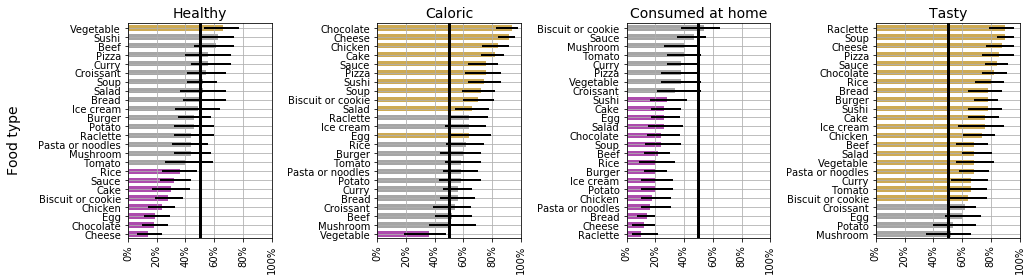

In [25]:
fig, axes = plt.subplots(1,4, figsize = (14,4), sharex = True, sharey = False)

for c,outcome in enumerate(['Answer.healthy', 'Answer.caloric',  'Answer.homemade','Answer.tasty']):
    sbplt = axes[c]
    
    colors = []
    
    tmp = df_results.loc[df_results['outcome'] == outcome].sort_values(by = 'median_twitter_bootstrapped_estimate')
    for cnt,i in enumerate(tmp['wins_p_val']<.05):
        if tmp['median_twitter_bootstrapped_estimate'].values[cnt]>50 and \
            tmp['median_twitter_lower_error'].values[cnt]>50:
            colors.append('darkgoldenrod')
        elif tmp['median_twitter_bootstrapped_estimate'].values[cnt]<50 and \
            tmp['median_twitter_upper_error'].values[cnt]<50:
            colors.append('darkmagenta')
        else:
            colors.append('gray')

    sbplt.barh(range(24),tmp['median_twitter_bootstrapped_estimate'],
               color = colors, height = 0.6, alpha = 0.7,
              xerr = np.array([tmp['median_twitter_bootstrapped_estimate'].values - tmp['median_twitter_lower_error'].values,
                     tmp['median_twitter_upper_error'].values - tmp['median_twitter_bootstrapped_estimate'].values]),
              error_kw=dict(lw = 2, alpha = 1))
    sbplt.set_yticks(range(24))
    sbplt.set_yticklabels(tmp['category'].apply(lambda x: x.capitalize()), rotation = 0);
    
    sbplt.set_xticks([0,20,40,60,80,100])
    sbplt.set_xticklabels(["0%","20%","40%","60%","80%","100%"], rotation = 90)
    sbplt.set_xlim([0,100])
    sbplt.set_ylim([-0.4,23.5])

    sbplt.vlines(50,-1,25, linewidth = 3)
    if outcome == 'Answer.homemade':
        sbplt.set_title('Consumed at home', fontsize= 14)
    else:
        sbplt.set_title(outcome.split('.')[1].capitalize(), fontsize= 14)
    
    sbplt.grid()

fig.tight_layout()

#fig.text(0.5, -0.04, 'Rank of median Twitter image among logged images', ha='center', fontsize= 12)
fig.text(-0.02, 0.5, 'Food type', va='center', rotation='vertical', fontsize= 14)

plt.savefig('figures/top.pdf',  bbox_inches = "tight")

In [26]:
for c,outcome in enumerate(outcomes):
    print(outcome)
    sbplt = axes[c]
    
    colors = []
    
    tmp = df_results.loc[df_results['outcome'] == outcome].sort_values(by = 'median_twitter_bootstrapped_estimate')
    
    for cnt,i in enumerate(tmp['wins_p_val']<.05):
        print(tmp['category'].values[cnt])
        print(tmp['median_twitter_lower_error'].values[cnt])
        print(tmp['median_twitter_bootstrapped_estimate'].values[cnt])
        print(tmp['median_twitter_upper_error'].values[cnt])
        if tmp['median_twitter_bootstrapped_estimate'].values[cnt]>50 and \
            tmp['median_twitter_lower_error'].values[cnt]>50:
            colors.append('tab:blue')
        elif tmp['median_twitter_bootstrapped_estimate'].values[cnt]<50 and \
            tmp['median_twitter_upper_error'].values[cnt]<50:
            colors.append('tab:red')
        else:
            colors.append('Gray')
    print('\n')

Answer.tasty
mushroom
34.95
52.0
66.0
potato
40.0
54.0
70.0
egg
48.0
60.0
73.04999999999998
croissant
50.0
62.0
70.0
biscuit or cookie
50.95
64.0
77.04999999999998
tomato
50.95
66.0
77.04999999999998
curry
52.0
66.0
78.0
pasta or noodles
58.0
68.0
79.04999999999998
vegetable
56.0
68.0
82.0
salad
60.0
68.0
81.04999999999998
beef
56.0
68.0
78.0
chicken
60.95
74.0
83.04999999999998
ice cream
56.95
76.0
89.04999999999998
cake
64.0
76.0
86.0
sushi
64.0
78.0
88.0
burger
68.0
78.0
85.04999999999998
bread
64.0
78.0
88.0
rice
68.95
80.0
89.04999999999998
chocolate
74.0
82.0
91.04999999999998
sauce
76.0
84.0
92.0
pizza
74.0
86.0
96.0
cheese
76.94999999999999
88.0
96.0
soup
84.0
90.0
96.0
raclette
78.95
90.0
96.0


Answer.caloric
vegetable
18.950000000000003
36.0
48.0
mushroom
36.0
50.0
69.04999999999998
beef
40.0
52.0
66.0
croissant
38.95
54.0
65.04999999999998
bread
44.0
56.0
68.0
curry
46.0
56.0
66.0
potato
42.95
58.0
72.0
pasta or noodles
46.0
58.0
70.0
tomato
46.95
58.0
72.09999999999997
bur

In [27]:
'''
fig, axes = plt.subplots(1,4, figsize = (14,4), sharex = True, sharey = False)

for c,outcome in enumerate(outcomes):
    
    sbplt = axes[c]
    
    colors = []
    
    tmp = df_results.loc[df_results['outcome'] == outcome].sort_values(by = 'median_twitter_bootstrapped_estimate')
    for cnt,i in enumerate(tmp['wins_p_val']<.05):
        if tmp['median_twitter_bootstrapped_estimate'].values[cnt]>50 and \
            tmp['median_twitter_lower_error'].values[cnt]>50:
            colors.append('tab:blue')
        elif tmp['median_twitter_bootstrapped_estimate'].values[cnt]<50 and \
            tmp['median_twitter_upper_error'].values[cnt]<50:
            colors.append('tab:red')
        else:
            colors.append('Gray')

    sbplt.barh(range(24),tmp['median_twitter_bootstrapped_estimate'],
               color = colors, height = 0.6, alpha = 0.6,
              xerr = np.array([tmp['median_twitter_bootstrapped_estimate'].values - tmp['median_twitter_lower_error'].values,
                     tmp['median_twitter_upper_error'].values - tmp['median_twitter_bootstrapped_estimate'].values]),
              error_kw=dict(lw = 2, alpha = 1))
    sbplt.set_yticks(range(24))
    sbplt.set_yticklabels(tmp['category'].apply(lambda x: x.capitalize()), rotation = 0);
    
    sbplt.set_xticks([0,20,40,60,80,100])
    sbplt.set_xticklabels(["0%","20%","40%","60%","80%","100%"], rotation = 90)
    sbplt.set_xlim([0,100])
    sbplt.set_ylim([-0.4,23.5])

    sbplt.vlines(50,-1,25, linewidth = 3)
    if outcome == 'Answer.homemade':
        sbplt.set_title('Consumed at home', fontsize= 14)
    else:
        sbplt.set_title(outcome.split('.')[1].capitalize(), fontsize= 14)
    
    sbplt.grid()

fig.tight_layout()

#fig.text(0.5, -0.04, 'Rank of median Twitter image among logged images', ha='center', fontsize= 12)
fig.text(-0.02, 0.5, 'Food category', va='center', rotation='vertical', fontsize= 14)

#plt.savefig('figures/top.pdf',  bbox_inches = "tight") 
''';

## e) Correlations

In [28]:
cs = []
cas = []
for c,gr in df_results.groupby('category'):
    cas.append(c)
    m = []

    for i,g1 in gr[['outcome','BTs']].iterrows():
        l = []
        for j,g2 in gr[['outcome','BTs']].iterrows():

            l.append(stats.spearmanr(list(g1['BTs']['estimated'].values()),list(g2['BTs']['estimated'].values()))[0])
        m.append(l)
    cs.append(m)

In [29]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



In [30]:
df_images = pd.read_pickle('data/df_results_images.pickle')

In [31]:
cs = []
cas = []
m1 = []
m2 = []

for i in ['BT_caloric', 'BT_healthy', 'BT_homemade','BT_tasty']:
    cas.append(i)
    l1 = []
    l2 = []
    for j in ['BT_caloric', 'BT_healthy', 'BT_homemade','BT_tasty']:
        l1.append(stats.spearmanr(df_images[i],df_images[j])[0])
        l2.append(stats.spearmanr(df_images[i],df_images[j])[1])
    m1.append(l1)
    m2.append(l2)
    

In [32]:
np.array(m2)<0.05

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

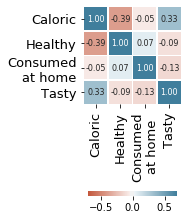

In [33]:
cnt = 15
# Generate a mask for the upper triangle


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4,4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(m1, cmap=cmap, vmin = -0.7,vmax=0.7, center=0,cbar = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .4, "orientation":'horizontal', "pad":0.4},annot=True, fmt=".2f",annot_kws={"fontsize":8})

plt.xticks(np.array(range(4))+0.5,['Caloric','Healthy','Consumed\nat home','Tasty'], rotation = 90,fontsize= 13);
plt.yticks(np.array(range(4))+0.5,['Caloric','Healthy','Consumed\nat home','Tasty'], rotation = 0,fontsize= 13);

fig.tight_layout()
plt.savefig('figures/corr.pdf', bbox_inches = "tight") 

## f) Regression

In [34]:
df_images['BT_tasty'] = (df_images['BT_tasty'] - df_images['BT_tasty'].mean()) \
    / df_images['BT_tasty'].std()

df_images['BT_caloric'] = (df_images['BT_caloric'] - df_images['BT_caloric'].mean()) \
    / df_images['BT_caloric'].std()

    
df_images['BT_healthy'] = (df_images['BT_healthy'] - df_images['BT_healthy'].mean()) \
    / df_images['BT_healthy'].std()

    
df_images['BT_homemade'] = (df_images['BT_homemade'] - df_images['BT_homemade'].mean()) \
    / df_images['BT_homemade'].std()



In [35]:
logit_model=smf.logit("Twitter ~ BT_caloric + BT_healthy + BT_homemade + BT_tasty", data = df_images)

result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.613240
         Iterations 5


In [36]:
print(result.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.115     
Dependent Variable: Twitter          AIC:              2953.5535 
Date:               2022-04-24 13:14 BIC:              2982.4696 
No. Observations:   2400             Log-Likelihood:   -1471.8   
Df Model:           4                LL-Null:          -1663.6   
Df Residuals:       2395             LLR p-value:      9.9447e-82
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     0.0027    0.0444    0.0607  0.9516  -0.0842   0.0896
BT_caloric    0.2658    0.0516    5.1539  0.0000   0.1647   0.3668
BT_healthy   -0.0332    0.0477   -0.6947  0.4872  -0.1267   0.0604
BT_homemade  -0.6126    0.0481

In [86]:
for measure in ['BT_tasty','BT_caloric','BT_healthy','BT_homemade']:
    print('b(T,M)'+measure.split('_')[1])
    ys = []
    for iteration in range(100):

        quality_real_estimated = df_images.loc[(df_images['Twitter']==1)][measure].sample(2400, replace = True).values
        quality_twitter_estimated = df_images.loc[(df_images['Twitter']==0)][measure].sample(2400, replace = True).values

        ys.append(np.mean(quality_real_estimated) - np.mean(quality_twitter_estimated))

    lower_error = np.percentile(ys, 2.5)
    upper_error = np.percentile(ys, 97.5)

    print(round(np.mean(df_images.loc[(df_images['Twitter']==1)][measure].values) - \
    np.mean(df_images.loc[(df_images['Twitter']==0)][measure].values),2),'[',
    round(lower_error,2), round(upper_error,2),']')
    
    print('\n')

b(T,M)tasty
0.52 [ 0.46 0.56 ]


b(T,M)caloric
0.39 [ 0.34 0.45 ]


b(T,M)healthy
-0.18 [ -0.24 -0.12 ]


b(T,M)homemade
-0.58 [ -0.62 -0.53 ]




In [ ]:
for measure in ['BT_tasty','BT_caloric','BT_healthy','BT_homemade']:
    print('b(T,M)'+measure.split('_')[1])
    ys = []
    for iteration in range(100):

        quality_real_estimated = df_images.loc[(df_images['Twitter']==1)][measure].sample(2400, replace = True).values
        quality_twitter_estimated = df_images.loc[(df_images['Twitter']==0)][measure].sample(2400, replace = True).values

        ys.append((np.mean(quality_real_estimated) - np.mean(quality_twitter_estimated))

    lower_error = np.percentile(ys, 2.5)
    upper_error = np.percentile(ys, 97.5)

    print(round(np.mean(df_images.loc[(df_images['Twitter']==1)][measure].values) - \
    np.mean(df_images.loc[(df_images['Twitter']==0)][measure].values),2),'[',
    round(lower_error,2), round(upper_error,2),']')
    
    print('\n')